In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import image

import sys
from pathlib import Path

sys.path.append(str(Path().resolve().parent))
#sys.path.append(str(Path(__file__).resolve().parent.parent))

from os import listdir
from os.path import isfile, join

import tensorflow as tf

from tensorflow.keras import callbacks, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, GlobalAveragePooling2D
from keras.applications import MobileNet, EfficientNetB3
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import average_precision_score

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

from tools.metrics import AveragePrecisionCallback

Note: Use conda tf-gpu environment. Copy of exp10 with more data (page 3 in api request)

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
spec_dir = '../data/image_data/'
sample_dir = '../data/image_data/Polistes_dominula/'

paths_sample_plot = [join(sample_dir, f) for f in listdir(sample_dir) if isfile(join(sample_dir, f))]

Define Batch size

In [14]:
num_classes = 130
batch_size = 32

## B - <a name="generateurs"></a> Data Generators



In [8]:
train_data_generator = ImageDataGenerator(rescale = 1./255,
                                    validation_split = 0.2,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    brightness_range=(0.8, 1.2),
                                    fill_mode='nearest'
                                   )

val_data_generator = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                   )

test_data_generator  = ImageDataGenerator(rescale = 1./255)
data_generator  = ImageDataGenerator(rescale = 1./255)

- (d) Implement ```training_data```, ```valid_data``` splits


In [9]:
training_data  = train_data_generator.flow_from_directory(directory = spec_dir,
                                                   target_size = (224, 224),
                                                   class_mode = 'binary',
                                                   subset = "training", 
                                                   batch_size = batch_size)

validation_data  = val_data_generator.flow_from_directory(directory = spec_dir,
                                                   target_size = (224, 224),
                                                   class_mode = 'binary',
                                                   subset = "validation", 
                                                   batch_size = batch_size)

#test_data  = test_data_generator.flow_from_directory(directory = spec_dir,
#                                                   target_size = (224, 224),
#                                                   class_mode = 'binary',
#                                                   batch_size = batch_size)


Found 48052 images belonging to 130 classes.
Found 11950 images belonging to 130 classes.


# II - <a name="classif"></a> Classification



In [19]:
# Model MobileNet
base_model = MobileNet(weights='imagenet', include_top=False)

# Freezer les couches
#for layer in base_model.layers:
#    layer.trainable = False


"""
# Unfreeze the last N trainable convolutional blocks
trainable = False
for layer in reversed(base_model.layers):
    if 'conv' in layer.name:
        if N == 0:
            break
        N -= 1
        trainable = True
    layer.trainable = trainable
"""

model = Sequential()
model.add(base_model) # Ajout du modèl
model.add(GlobalAveragePooling2D())
model.add(Dropout(rate=0.3))
model.add(Dense(units=1024, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

/tmp/ipykernel_1008684/671354210.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False)


In [20]:
early_stopping = callbacks.EarlyStopping(monitor = 'val_accuracy',
                                         patience = 10,
                                         mode = 'max',
                                         restore_best_weights = True)

lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                        patience=4,
                                         factor=0.5,
                                         verbose=2,
                                         mode='max',
                                         min_lr = 1e-10)

In [21]:
optimizer = Adam(learning_rate=0.001) 

In [27]:
ap_callback = AveragePrecisionCallback(validation_data, num_classes)

In [23]:
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [25]:
history = model.fit(training_data, validation_data=validation_data, epochs=1, 
                    callbacks=[ap_callback,lr_plateau, early_stopping])

1502/1502 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.4611 - loss: 1.9614

NameError: name 'np' is not defined

NameError: name 'history' is not defined

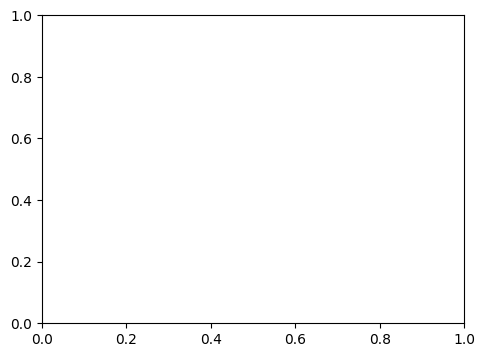

In [28]:
# Go up one level to reach project root (same as src/parent)
project_root = Path().resolve().parent

# Define save path
save_path = project_root / "results" / "figures"
save_path.mkdir(parents=True, exist_ok=True)

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='right')


plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='right')

# Save it to file (no display)
plt.tight_layout()  # optional: improves spacing
plt.savefig(save_path / "exp11_loss_acc.png", dpi=300, bbox_inches='tight')

# Close the figure to free memory (important in notebooks)
plt.close()


In [16]:
model.save('../models/model_127_species_exp7.h5')